In [1]:
#kmeans

In [1]:
#Traemos las librerías que vamos a usar
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import zipfile
from scipy.io import loadmat
from urllib.request import urlretrieve
from os.path import isfile, isdir
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
from scipy.io import loadmat
import glob
import matplotlib.image as img
# Install pillow
from PIL import Image

d_name = 'C:\\GitHub\\Estadistica3_2023-2\\Tarea2\\data\\faces\\rawdata'
X = []

for nfile in os.listdir(d_name):
    bytes_read = open(os.path.join(d_name, nfile), "rb").read()
    img_data = Image.frombytes('L', (128, 128), bytes_read)
    X.append(np.array(img_data).flatten())

X = np.array(X)

In [3]:
X.shape

(3993, 16384)

In [4]:
# Reducción de dimensionalidad utilizando PCA para obtener las 5 primeras componentes
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

In [5]:
def absolute_distance(point1, point2):
    return np.sum(np.abs(point1 - point2))

# Algoritmo K-Means sin librerías
class KMeans:
    def __init__(self, n_clusters=7, max_iters=200):
        self.n_clusters = n_clusters
        self.max_iters = max_iters

    def fit(self, X):
        # Inicialización aleatoria de centroides
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for iteration in range(self.max_iters):
            # Asignar puntos al centroide más cercano
            distances = np.array([[absolute_distance(x, c) for c in self.centroids] for x in X])
            labels = np.argmin(distances, axis=1)

            # Actualizar los centroides
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])

            # Comprobar la convergencia
            if np.all(self.centroids == new_centroids):
                print(f"El algoritmo ha convergido en la iteración {iteration}.")  # Imprime el número de iteración
                break

            self.centroids = new_centroids

    def predict(self, X):
        distances = np.array([[absolute_distance(x, c) for c in self.centroids] for x in X])
        labels = np.argmin(distances, axis=1)
        return labels

In [6]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_pca)
predicted_labels = kmeans.predict(X_pca)

El algoritmo ha convergido en la iteración 42.


In [7]:
#Seleccionar las 4 caras más cercanas al centroide de cada cluster
selected_faces = []
for cluster_id in range(7):
    cluster_indices = np.where(predicted_labels == cluster_id)[0]
    cluster_centroid = kmeans.centroids[cluster_id]
    
    # Calcular distancias desde el centroide del cluster
    distances_to_centroid = [absolute_distance(X_pca[i], cluster_centroid) for i in cluster_indices]
    
    # Seleccionar las 4 caras más cercanas
    sorted_indices = np.argsort(distances_to_centroid)
    selected_faces.extend(cluster_indices[sorted_indices[:4]])

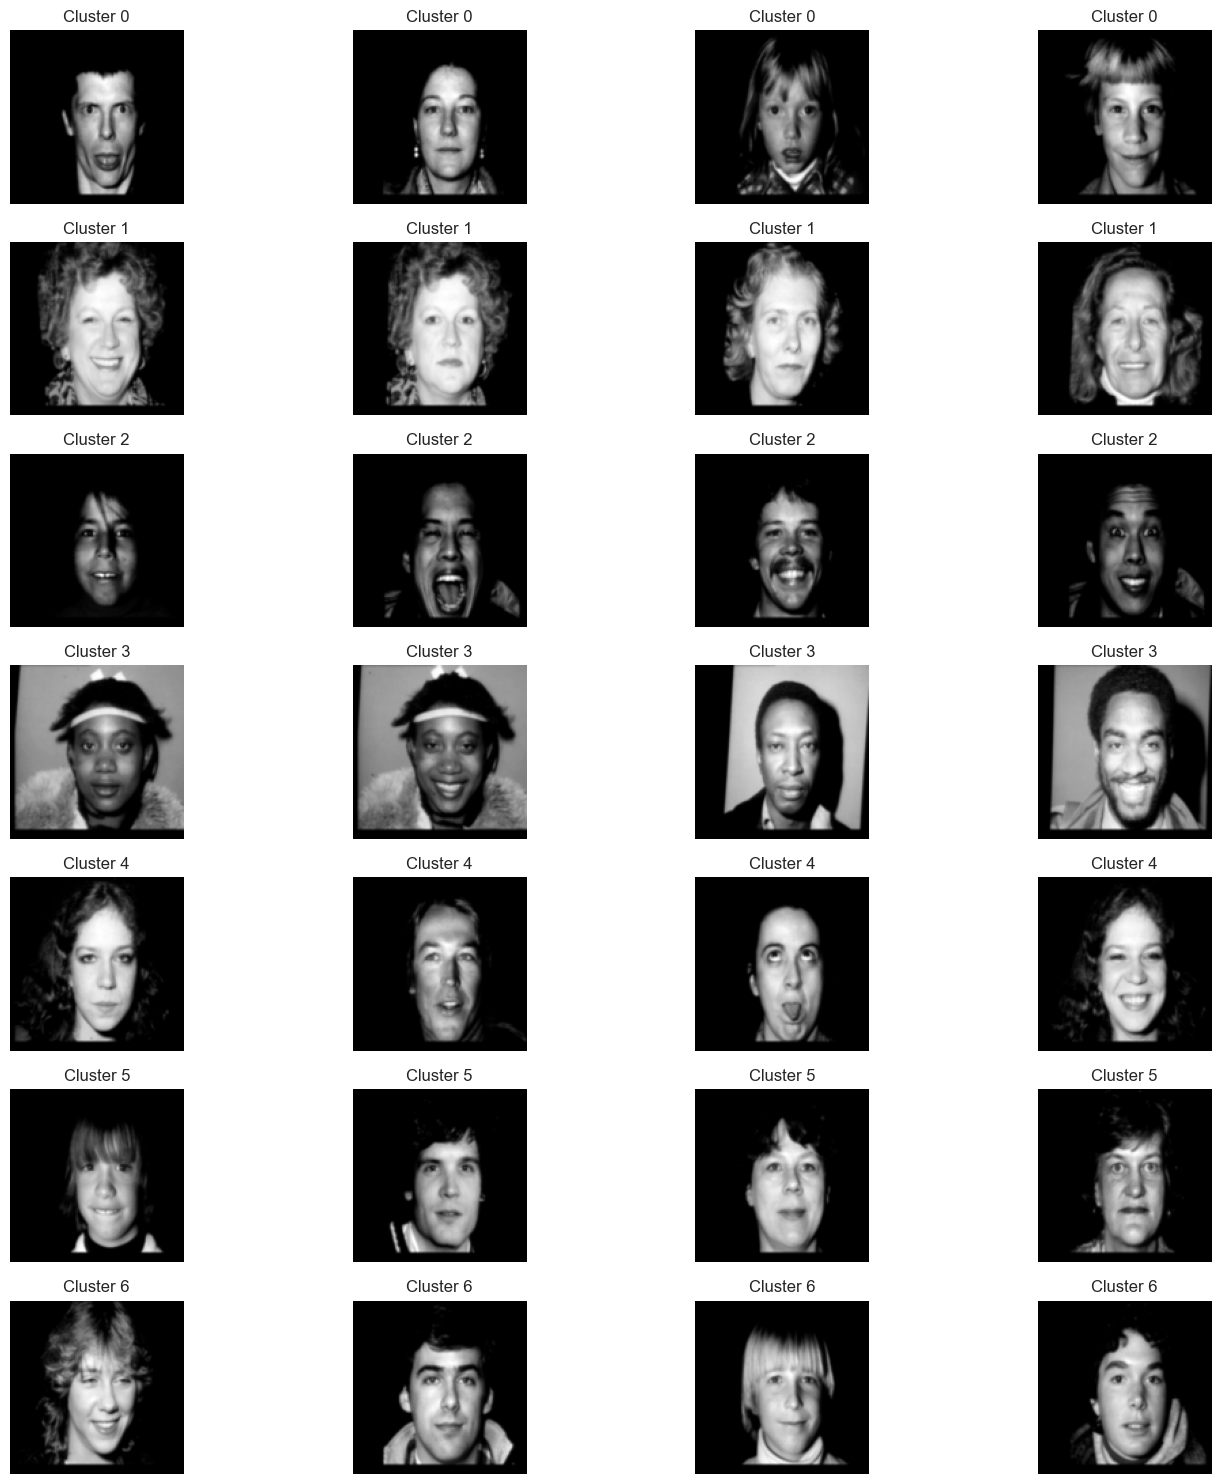

In [8]:
#Visualizar y describir las caras seleccionadas
plt.figure(figsize=(15, 15))
for i, face_idx in enumerate(selected_faces):
    plt.subplot(7, 4, i + 1)
    plt.imshow(X[face_idx].reshape(128, 128), cmap='gray')  # Usar X en lugar de data
    plt.title(f'Cluster {predicted_labels[face_idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()